# Tutorial 2: Using ``CAP``

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/docs/examples/tutorial-2.ipynb)

The ``CAP`` class is designed to perform CAPs analyses (on all subjects or group of subjects). It offers the flexibility
to analyze data from all subjects or focus on specific groups, compute CAP-specific metrics, and generate visualizations
to aid in the interpretation of results.


In [1]:
# Allow plotly to render correctly on static websites
import plotly.io as pio

pio.renderers.default = "svg"

# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

# Performing CAPs on All Subjects
All information pertaining to CAPs (k-means models, activation vectors/cluster centroids, etc) are stored as attributes
in the ``CAP`` class and this information is used by all methods in the class. These attributes are accessible via
[properties](https://neurocaps.readthedocs.io/en/stable/generated/neurocaps.analysis.CAP.html#properties).
**Some properties can also be used as setters.**

2025-07-21 14:30:47,573 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2025-07-21 14:30:47,797 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: elbow] Optimal cluster size is 4.


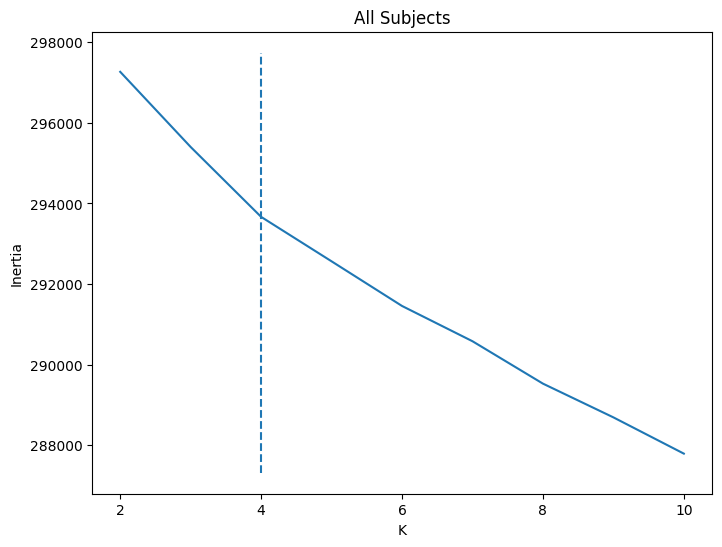

In [2]:
import numpy as np
from neurocaps.analysis import CAP
from neurocaps.utils import PlotDefaults

np.random.seed(0)

# Extracting timseries
parcel_approach = {"Schaefer": {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 2}}

# Simulate data for example
subject_timeseries = {
    str(x): {f"run-{y}": np.random.rand(100, 100) for y in range(1, 4)} for x in range(1, 11)
}

# Initialize CAP class
cap_analysis = CAP(parcel_approach=parcel_approach)

# Get CAPs
plot_kwargs = {**PlotDefaults.get_caps(), "step": 2}

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    n_clusters=range(2, 11),
    cluster_selection_method="elbow",
    show_figs=True,
    progress_bar=False,
    **plot_kwargs,
)

``print`` can be used to return a string representation of the ``CAP`` class.

In [3]:
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : All Subjects
Number of Clusters                                          : [2, 3, 4, 5, 6, 7, 8, 9, 10]
Cluster Selection Method                                    : elbow
Optimal Number of Clusters (if Range of Clusters Provided)  : {'All Subjects': np.int64(4)}
CPU Cores Used for Clustering (Multiprocessing)             : None
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 2400184 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'All Subjects': 4}
Variance Explained by Clustering                            : {'All Subjects': np.float64(0.02078377782910834)}


## Calculate Metrics

Note that if ``standardize`` was set to True in ``CAP.get_caps()``, then the column (ROI) means and standard deviations
computed from the concatenated data used to obtain the CAPs are also used to standardize each subject in the timeseries
data inputted into ``CAP.calculate_metrics()``. This ensures proper CAP assignments for each subjects frames.


In [4]:
df_dict = cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries,
    return_df=True,
    metrics=["temporal_fraction", "counts", "transition_probability"],
    continuous_runs=True,
    progress_bar=False,
)

df_dict["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4
0,1,All Subjects,run-continuous,0.233333,0.273333,0.256667,0.236667
1,10,All Subjects,run-continuous,0.233333,0.230000,0.296667,0.240000
2,2,All Subjects,run-continuous,0.213333,0.290000,0.213333,0.283333
3,3,All Subjects,run-continuous,0.243333,0.236667,0.250000,0.270000
4,4,All Subjects,run-continuous,0.256667,0.250000,0.253333,0.240000
5,5,All Subjects,run-continuous,0.216667,0.260000,0.233333,0.290000
6,6,All Subjects,run-continuous,0.263333,0.250000,0.256667,0.230000
7,7,All Subjects,run-continuous,0.236667,0.266667,0.226667,0.270000
8,8,All Subjects,run-continuous,0.233333,0.276667,0.246667,0.243333
9,9,All Subjects,run-continuous,0.220000,0.240000,0.270000,0.270000


## Plotting CAPs

2025-07-21 14:30:47,975 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.


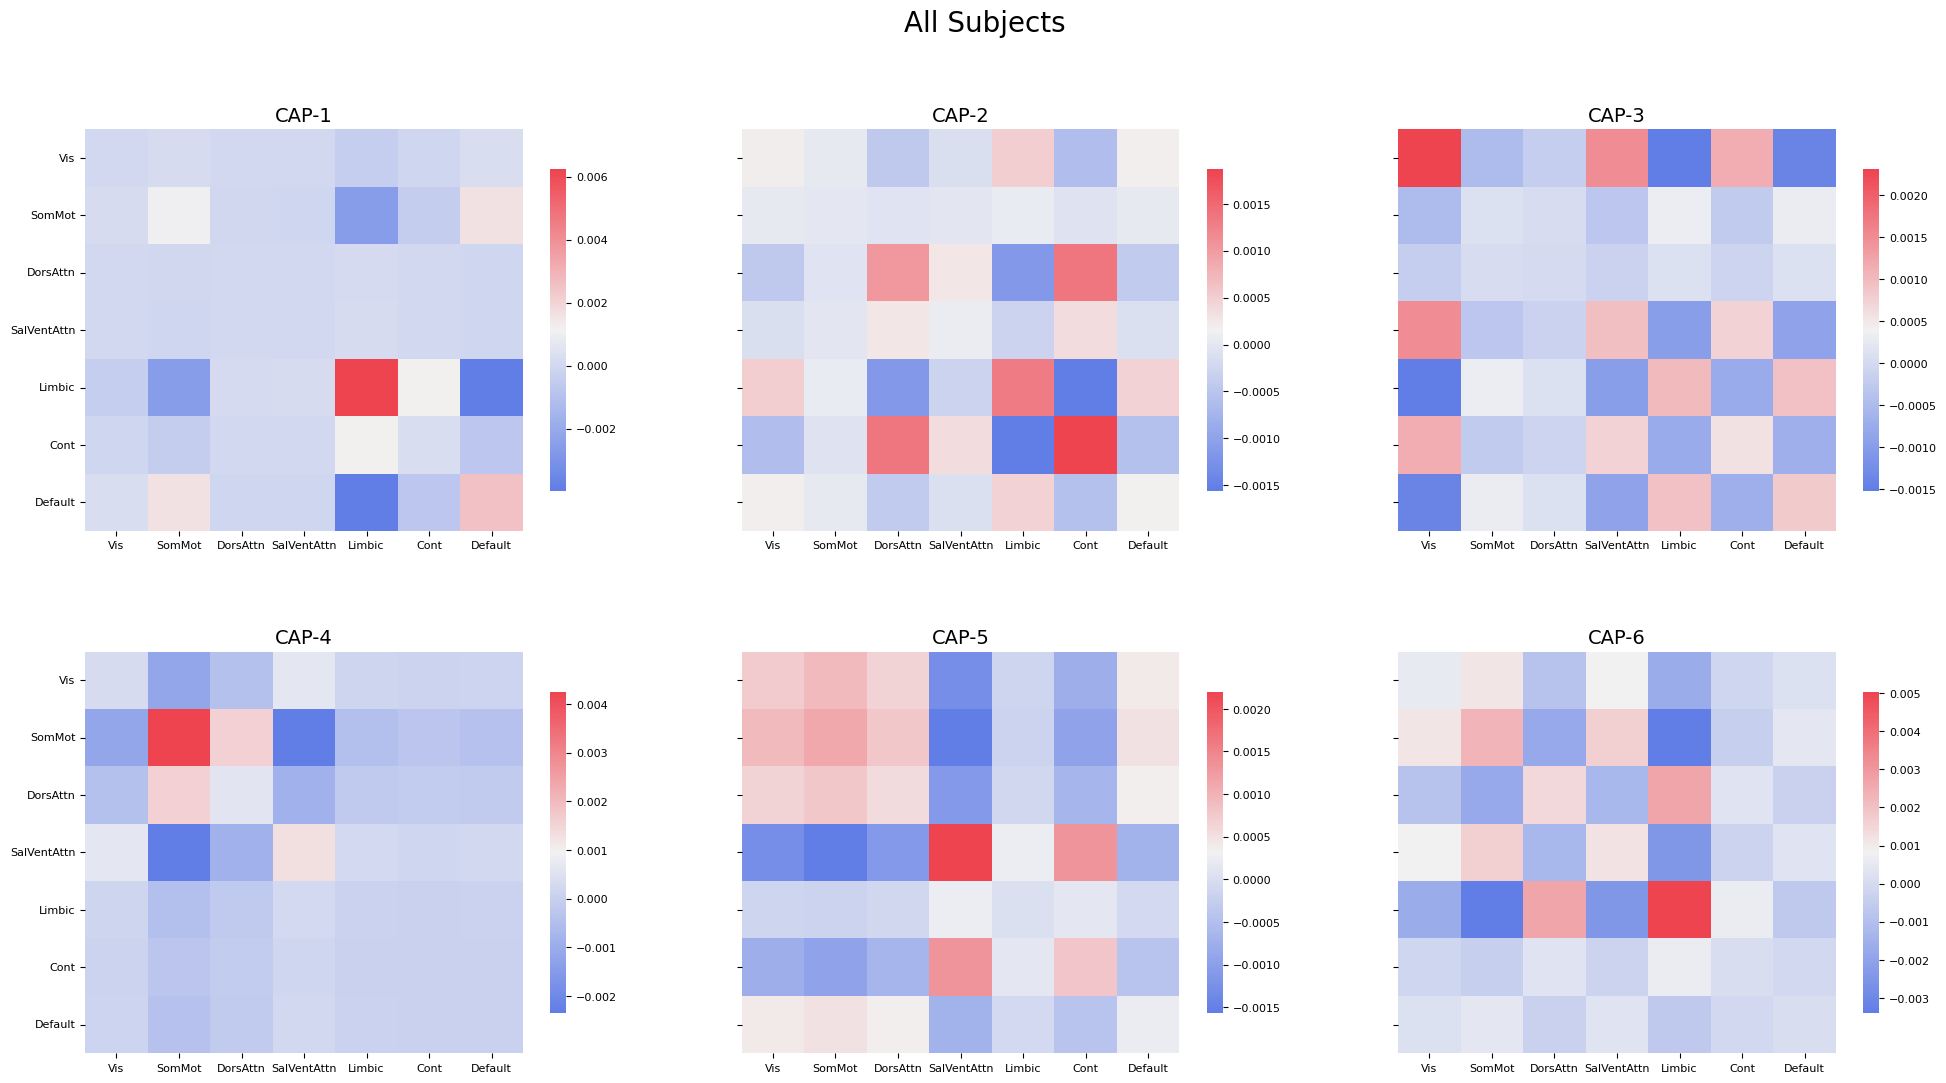

In [5]:
import seaborn as sns

cap_analysis = CAP(
    parcel_approach={"Schaefer": {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 1}}
)

cap_analysis.get_caps(subject_timeseries=subject_timeseries, n_clusters=6)

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(
    {
        "subplots": True,
        "fontsize": 14,
        "ncol": 3,
        "sharey": True,
        "tight_layout": False,
        "xlabel_rotation": 0,
        "hspace": 0.3,
        "cmap": palette,
    }
)

cap_analysis.caps2plot(
    visual_scope="regions", plot_options="outer_product", show_figs=True, **plot_kwargs
)

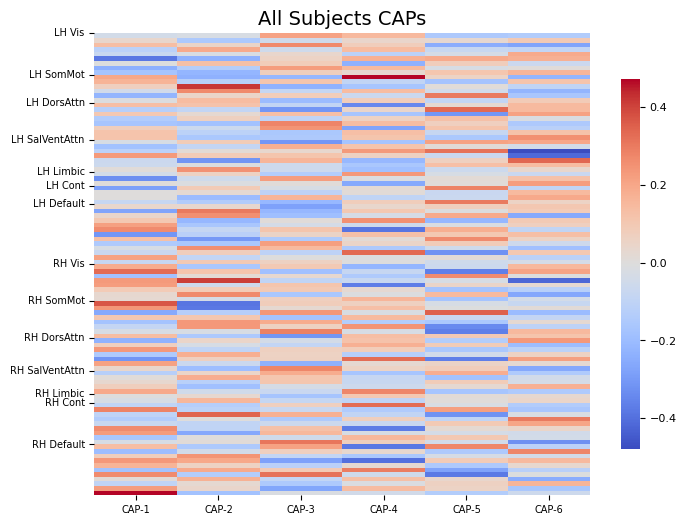

In [6]:
plot_kwargs = PlotDefaults.caps2plot()
plot_kwargs.update(dict(xticklabels_size=7, yticklabels_size=7))

cap_analysis.caps2plot(visual_scope="nodes", plot_options="heatmap", show_figs=True, **plot_kwargs)

## Generate Correlation Matrix

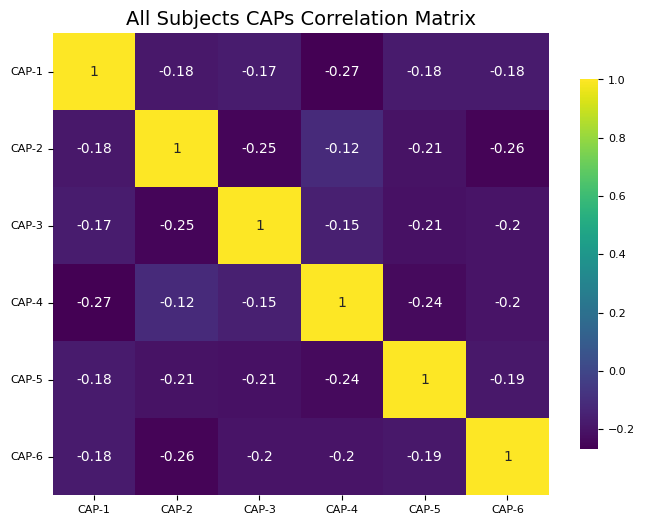

In [7]:
plot_kwargs = PlotDefaults.caps2corr()
plot_kwargs.update(dict(annot=True, cmap="viridis"))

cap_analysis.caps2corr(method="pearson", show_figs=True, **plot_kwargs)

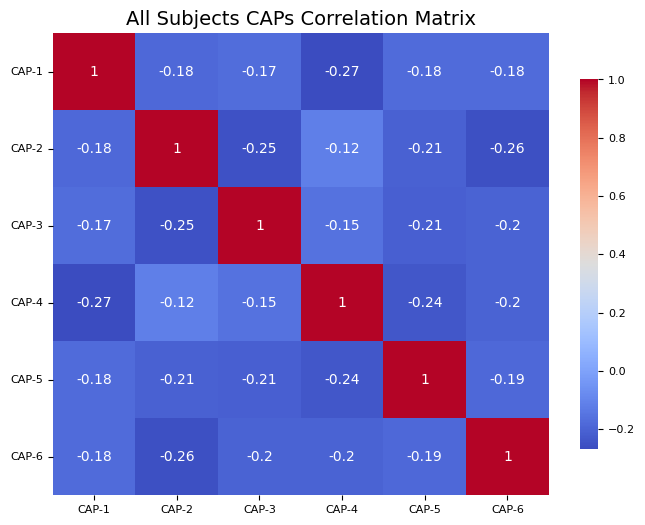

In [8]:
corr_dict = cap_analysis.caps2corr(method="pearson", return_df=True)

In [9]:
corr_dict["All Subjects"]

,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
CAP-1,1 (0)***,-0.18 (0.066),-0.17 (0.092),-0.27 (0.0071)**,-0.18 (0.078),-0.18 (0.079)
CAP-2,-0.18 (0.066),1 (0)***,-0.25 (0.012)*,-0.12 (0.24),-0.21 (0.038)*,-0.26 (0.01)*
CAP-3,-0.17 (0.092),-0.25 (0.012)*,1 (0)***,-0.15 (0.12),-0.21 (0.034)*,-0.2 (0.044)*
CAP-4,-0.27 (0.0071)**,-0.12 (0.24),-0.15 (0.12),1 (0)***,-0.24 (0.018)*,-0.2 (0.046)*
CAP-5,-0.18 (0.078),-0.21 (0.038)*,-0.21 (0.034)*,-0.24 (0.018)*,1 (0)***,-0.19 (0.061)
CAP-6,-0.18 (0.079),-0.26 (0.01)*,-0.2 (0.044)*,-0.2 (0.046)*,-0.19 (0.061),1 (0)***


## Creating Surface Plots


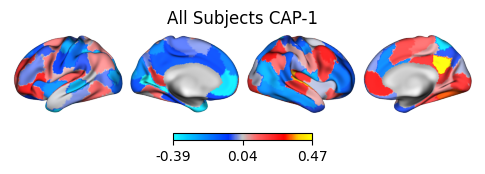

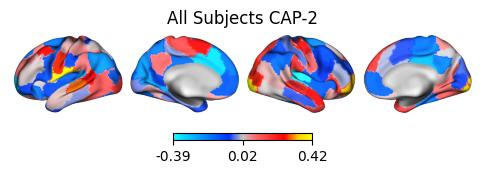

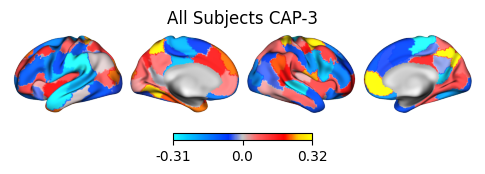

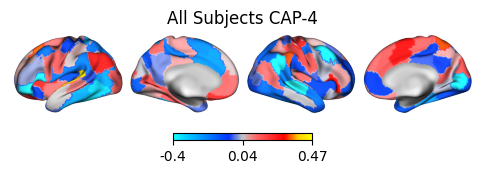

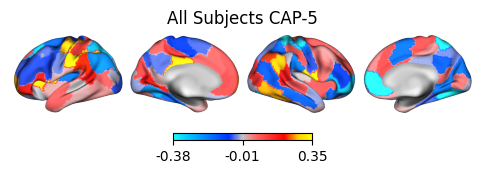

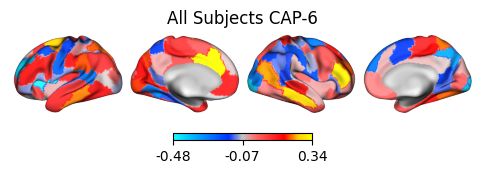

In [10]:
from matplotlib.colors import LinearSegmentedColormap

# Create the colormap
colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

plot_kwargs = PlotDefaults.caps2surf()
plot_kwargs.update(dict(cmap=custom_cmap, size=(500, 100), layout="row"))

# Apply custom cmap to surface plots
cap_analysis.caps2surf(progress_bar=False, **plot_kwargs)

## Plotting CAPs to Radar

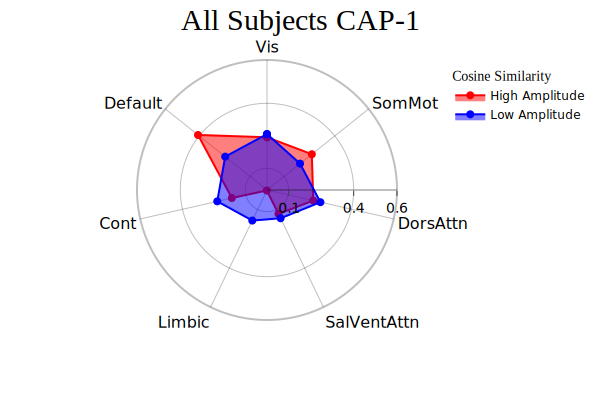

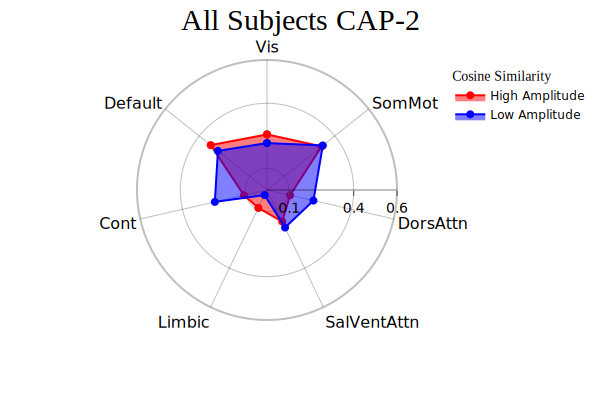

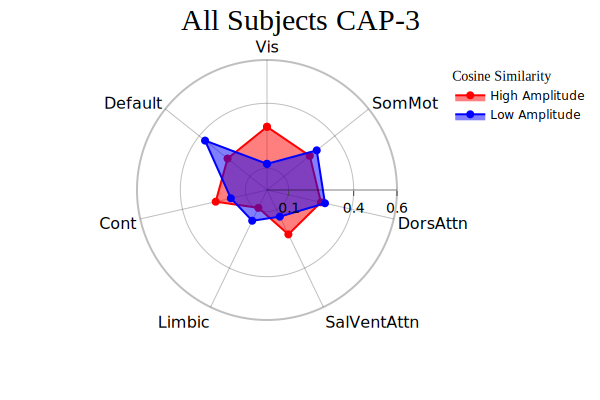

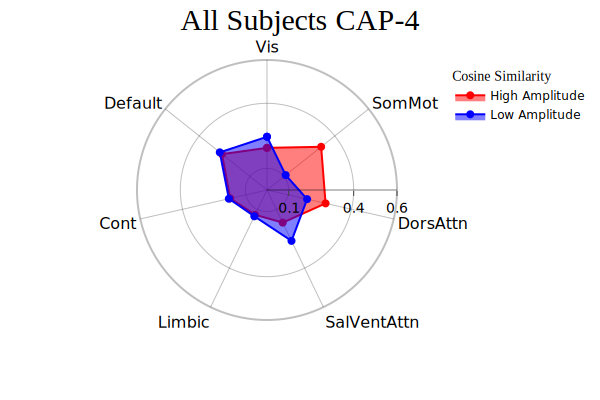

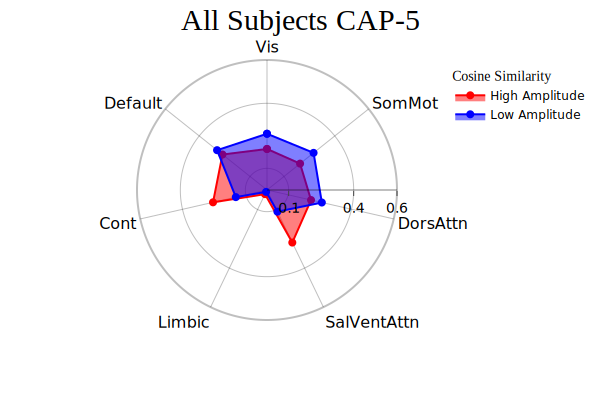

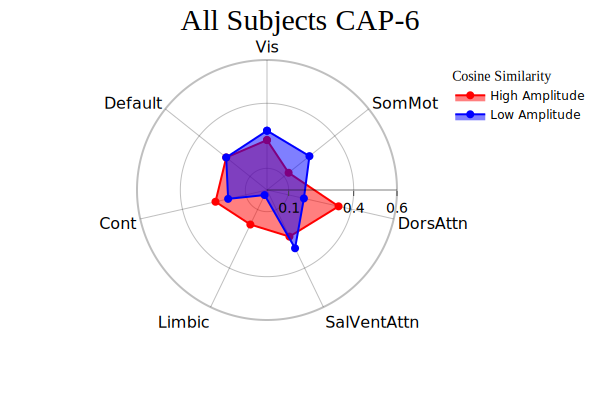

In [11]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.1, "", "", 0.4, "", "", 0.6],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "red", "Low Amplitude": "blue"}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(
    {
        "radialaxis": radialaxis,
        "fill": "toself",
        "legend": legend,
        "color_discrete_map": colors,
        "height": 400,
        "width": 600,
    }
)

cap_analysis.caps2radar(**plot_kwargs)

## Performing CAPs on Groups

2025-07-21 14:31:06,499 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: A | METHOD: silhouette] Optimal cluster size is 2.


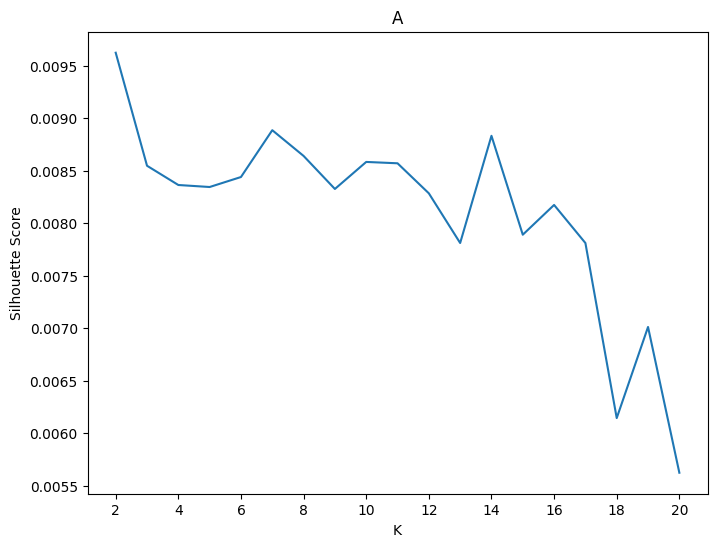

2025-07-21 14:31:07,639 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: B | METHOD: silhouette] Optimal cluster size is 2.


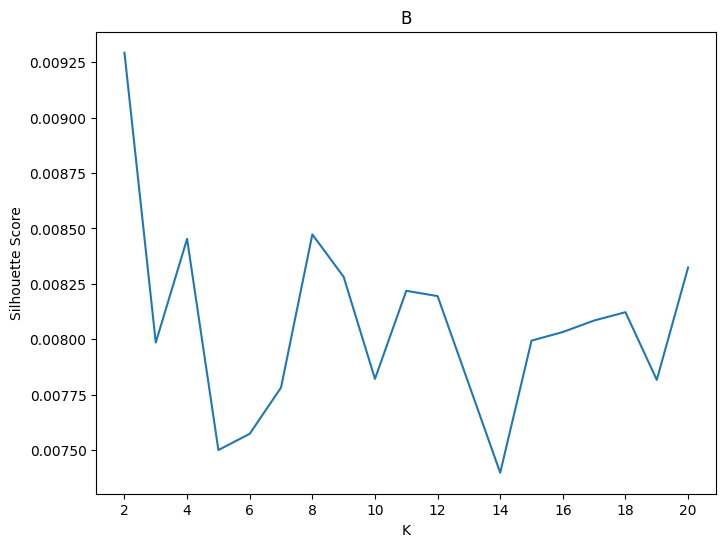

In [12]:
cap_analysis = CAP(groups={"A": ["1", "2", "3", "5"], "B": ["4", "6", "7", "8", "9", "10"]})

plot_kwargs = {**PlotDefaults.get_caps(), "step": 2}

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    n_clusters=range(2, 21),
    cluster_selection_method="silhouette",
    show_figs=True,
    progress_bar=False,
    **plot_kwargs,
)

# The concatenated data can be safely deleted since only the kmeans models and any
# standardization parameters are used for computing temporal metrics.
del cap_analysis.concatenated_timeseries